# Ciencia de Datos - TP4

## Integrantes

- Ambroa, Nicolás - 229/13 - ambroanicolas@hotmail.com
- Gaustein, Diego - 586/09 - diego@gaustein.com.ar

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import OrderedDict
from itertools import tee
from os import path
import pickle
from pprint import pprint


%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)
random.seed(42)

## 1. Creación del Grafo
A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de
nodos y aristas. Haga una representacion grafica del grafo.

In [2]:
all_authors = set()
author_string_cleaning_table = {ord(c): None for c in " "+"\\"+")"}

def create_graph():
    G = nx.Graph(name="Authors")
    csv = pd.read_csv("data.csv", names=["year", "code", "pub", "authors", "name"])
    for index, author_string in enumerate(csv["authors"]):
        authors = [a.translate(author_string_cleaning_table) for a in author_string.split("&")]
        all_authors.update(authors)
        if len(authors) == 1:
            G.add_nodes_from(authors)
        else:
            comb = combinations(authors, 2)
            G.add_edges_from(comb)
            
    return G

In [3]:
G = create_graph()
print(nx.info(G))

Name: Authors
Type: Graph
Number of nodes: 3994
Number of edges: 7856
Average degree:   3.9339


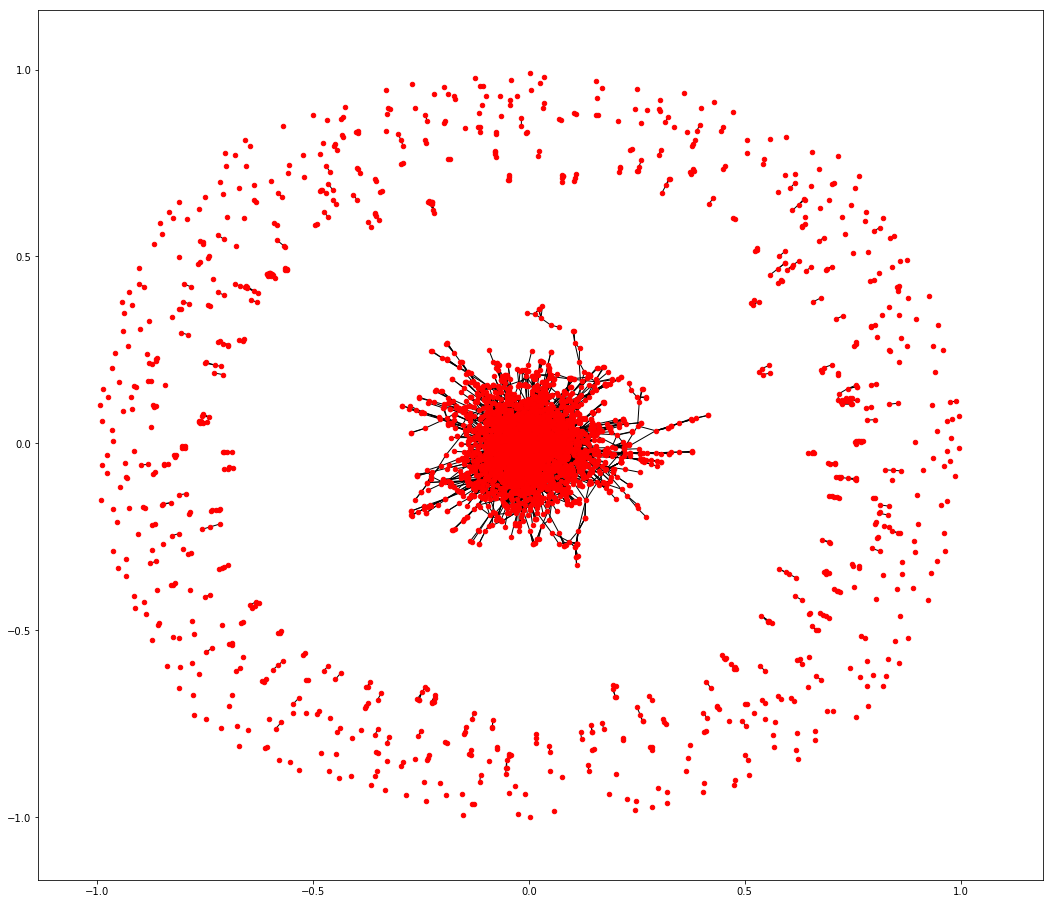

In [4]:
def draw_graph(G):
    plt.figure(figsize=(18, 16))
    nx.draw_networkx(G, node_size=20, with_labels=False)

draw_graph(G)

## 2. Distribución de Grado
Grafique la distribución del grado de los autores, en escalas lineales, semilogarıtmica, y log-log. Argumente, a partir de los graficos, de que tipo de distribucion se trata.

Gráfico de Distribución del Grado de los Autores en Escala Lineal

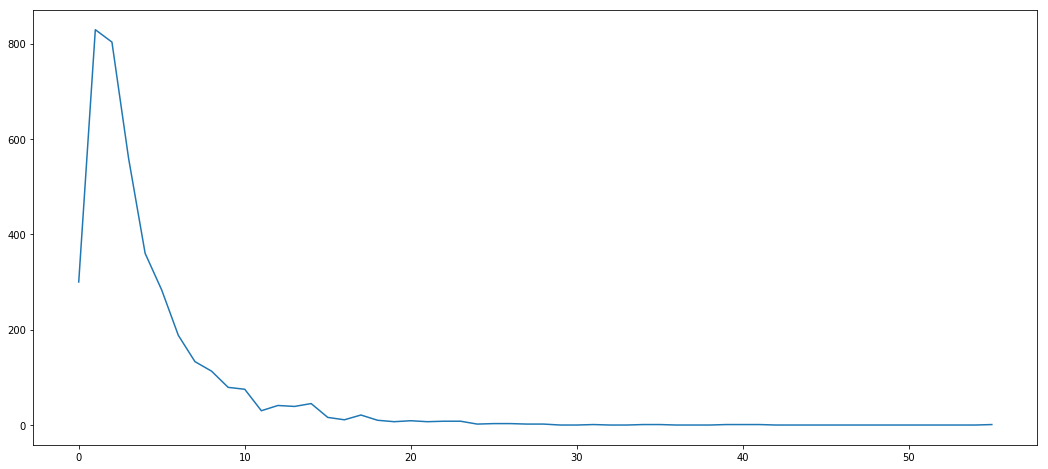

In [5]:
deg_histogram = nx.degree_histogram(G)
plt.plot(deg_histogram)

Mismo gráfico, pero en escala semi-log.

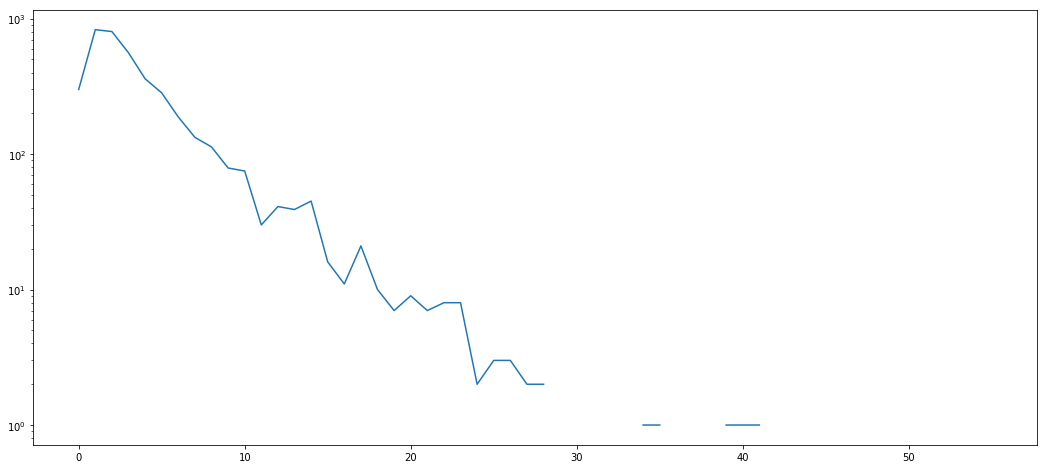

In [6]:
plt.semilogy(deg_histogram)

Mismo gráfico, pero en escala log-log.

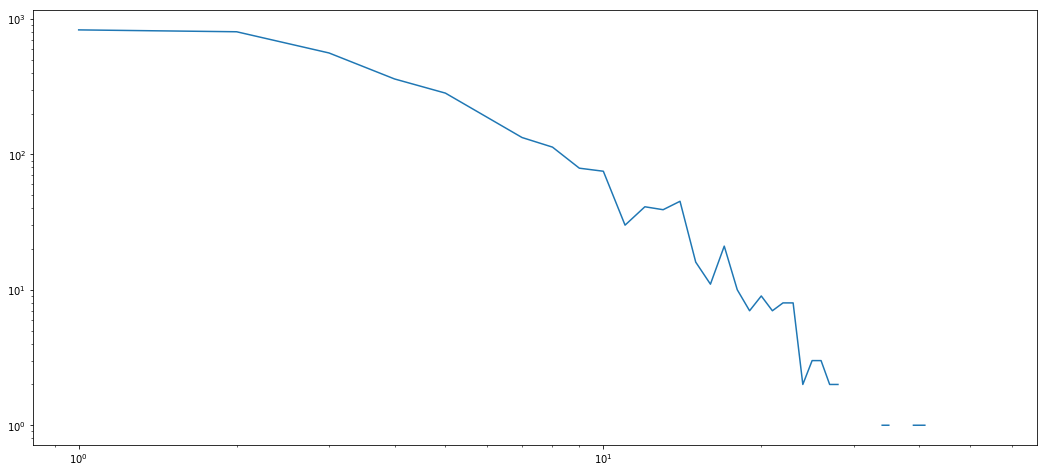

In [7]:
plt.loglog(deg_histogram)

Vista con el eje Y en escala logarítmica parece ser una línea recta, por lo que la distribución parecería ser una exponencial

## 3. Componentes Conexas
Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante.

In [8]:
amount_of_connected_components = nx.number_connected_components(G)
print('Cantidad de componentes conexas: {}'.format(amount_of_connected_components))

Cantidad de componentes conexas: 536


Buscamos la componente mayor para mostrar su tamaño.

In [9]:
connected_components = nx.connected_components(G)
biggest_connected_component = max(connected_components, key=len)
print("Tamaño de la componente mayor: {}".format(len(biggest_connected_component)))

Tamaño de la componente mayor: 3014


## 4. Tamaño de Vecindades
Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta
el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores
alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores
que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y
analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno
de seis grados de separación.

Generamos una función que nos da, para una componente, información de un nodo aleatorio almacenada en un diccionario de la forma

`{nodo: [distancia_a_source, cantidad_de_vecinos, set(vecinos)]}`

para él. Repetimos el proceso a medida que nos alejamos del nodo aleatorio, yendo por sus vecinos.

In [10]:
def generate_walk_info_from_component(component):
    random_node = random.choice(list(component))  # Elegimos un nodo aleatorio.
    neighbors_per_node = OrderedDict()
    succesors = nx.dfs_preorder_nodes(G, random_node)
    previous_distance = 0
    current_distance = 0
    for index, succesor in enumerate(succesors):
        previous_distance = current_distance
        current_distance = len(nx.shortest_path(G, succesor, random_node))
        if current_distance < previous_distance: break  # Termino cuando DFS recorrió toda la profundidad del grafo
        neighbors = nx.all_neighbors(G, succesor)  # Obtenemos vecinos del nodo.
        neighbors_set = set(neighbors)
        amount_of_neighbors = len(neighbors_set)
        # Generamos entrada de tipo nodo: [dist_a_source, cant_vecinos, vecinos]
        neighbors_per_node[succesor] =  [current_distance, amount_of_neighbors, neighbors_set]

    return random_node, neighbors_per_node

Generamos 2 funciones que nos dan los gráficos pedidos por el punto 4, para una componente y un nodo.

In [11]:
def graph_amount_of_reachable_authors(component, neighbors_per_node):
    reachable = set()
    reachable_count = []

    for node, (_, _, vecinos) in neighbors_per_node.items():
        reachable.update(vecinos)
        reachable_count.append(len(reachable))

    plt.plot(reachable_count)
    
def graph_difference_between_added_neighbors(component, neighbors_per_node):
    reachable = set()
    differences = []
    
    for node, (_, _, vecinos) in neighbors_per_node.items():
        prev_reachable_count = len(reachable)
        reachable.update(vecinos)
        differences.append(len(reachable) - prev_reachable_count)
    
    plt.plot(differences)
    return differences

In [12]:
# Iteramos aleatoriamente 50 veces, guardando la informacion de los vecinos del nodo aleatorio en una lista.
neighbors_per_node_list = []
for i in range(50):
    random_node, neighbors_per_node = generate_walk_info_from_component(biggest_connected_component)
    neighbors_per_node_list.append(neighbors_per_node)

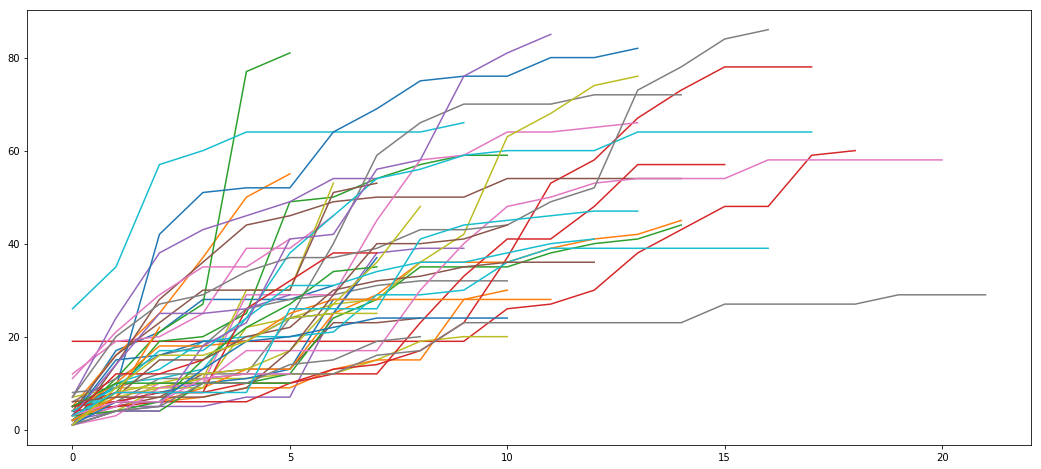

In [13]:
# Generamos el gráfico de cantidad de autores vs distancia.
for neighbors_per_node in neighbors_per_node_list:
    graph_amount_of_reachable_authors(biggest_connected_component, neighbors_per_node)

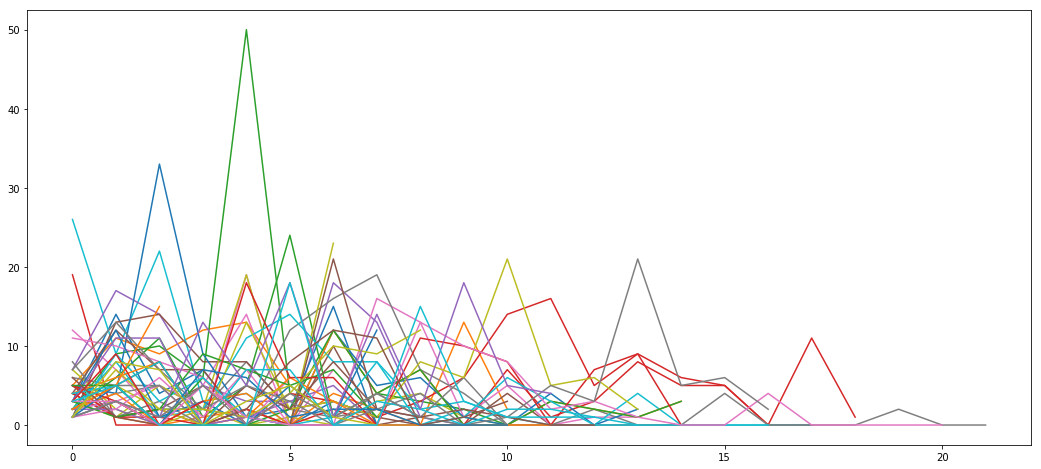

In [14]:
# Generamos el gráfico de diferencia de vecinos agregados vs distancia.
max_difference_per_random_node, max_difference_positions = [], []
for neighbors_per_node in neighbors_per_node_list:
    differences = graph_difference_between_added_neighbors(biggest_connected_component, neighbors_per_node)
    max_difference = max(differences)
    max_difference_per_random_node.append(max_difference)
    max_difference_positions.append(differences.index(max_difference))

El máximo de la función de número de nuevos autores que se agregan a cada paso es:

Máximo: 50
Media: 14.26


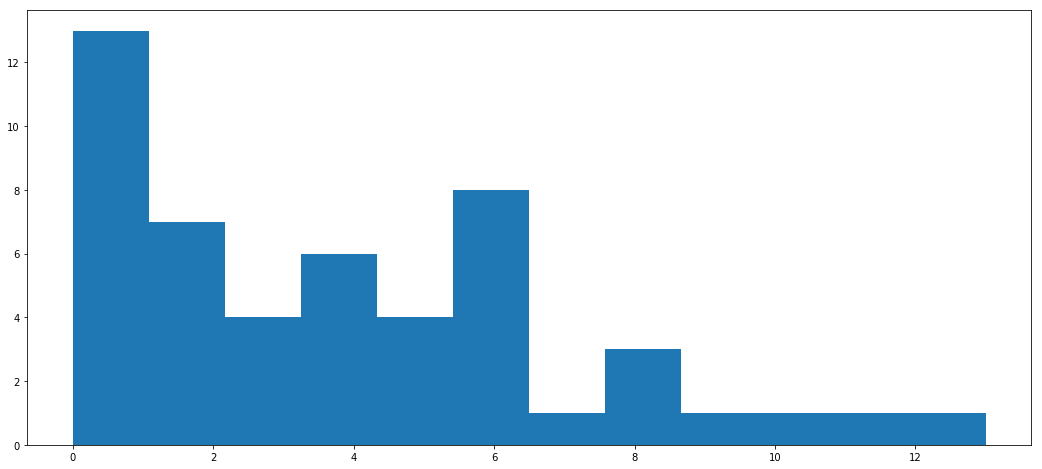

In [15]:
plt.hist(max_difference_positions, bins=12)
print('Máximo:', max(max_difference_per_random_node))
print('Media:', np.mean(max_difference_per_random_node))

De éstos gráficos, podemos concluir varias características de la distribución. Primero, los autores tienen una cantidad fuertemente variable de co-autores en distintos libros (visible por la amplia diferencia de cantidad de vecinos entre nodos). Además, parecerían tener pocos autores en común, ya que el gráfico que marca la diferencia de autores agregados entre nodos resulta muy similar en cantidad al gráfico de cantidad de co-autores. Al ser tan constantemente grande la diferencia de co-autores, los resultados parecerían indicar que uno podría, desde un autor, alcanzar a otro en una pequeña cantidad de saltos.

El máximo absoluto de nuevos autores agregados en un nuevo salto es de 48, mientras que la media de 15.28. Vemos en el histograma que el máximo en cada secuencia se alcanza con alta probabilidad en los primeros 5 saltos.

## 5. Mundos Pequeños

Compute el coeficiente de clustering C y el camino mínimo medio l para la componente gigante. Genere
un grafo aleatorio con la misma distribución de grado y compute las mismas medidas para este grafo.
Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequeños?

Computamos coeficiente de clustering y camino mínimo medio para la componente gigante.

In [16]:
clustering_coef = nx.average_clustering(G, biggest_connected_component)
biggest_connected_component_subgraph = G.subgraph(biggest_connected_component)
# Generamos un archivo para la longitud de camino minimo medio, al ser costoso de calcular.
if not path.exists('biggest_connected_component_avg_shortest_path_length'):
    with open('biggest_connected_component_avg_shortest_path_length', 'wb') as f:
        pickle.dump(nx.average_shortest_path_length(biggest_connected_component_subgraph), f)
        
with open('biggest_connected_component_avg_shortest_path_length', 'rb') as f:
    avg_shortest_path_length = pickle.load(f)
print("Coeficiente de Clustering: {} , Longitud de Camino Minimo Medio: {}".format(clustering_coef, avg_shortest_path_length))

Coeficiente de Clustering: 0.48318448792867486 , Longitud de Camino Minimo Medio: 6.119058730460418


Generamos un grafo aleatorio con la misma distribución de grado de la componente gigante. Luego, computamos las mismas métricas que para el grafo anterior.

In [17]:
deg_distribution = list([item[1] for item in nx.degree(biggest_connected_component_subgraph)])
random_graph = nx.configuration_model(deg_distribution, create_using=nx.Graph())
clustering_coef = nx.average_clustering(random_graph)
# Generamos la componente gigante para el grafo aleatorio, y luego un subgrafo de esta componente
random_graph_connected_components = nx.connected_components(random_graph)
random_graph_biggest_connected_component = max(random_graph_connected_components, key=len)
random_graph_biggest_connected_component_subgraph = random_graph.subgraph(random_graph_biggest_connected_component)
# Generamos un archivo para la longitud de camino minimo medio, al ser costoso de calcular.
if not path.exists('random_graph_avg_shortest_path_length'):
    with open('random_graph_avg_shortest_path_length', 'wb') as f:
        pickle.dump(nx.average_shortest_path_length(random_graph_biggest_connected_component_subgraph), f)
        
with open('random_graph_avg_shortest_path_length', 'rb') as f:
    avg_shortest_path_length = pickle.load(f)
    
print("Coeficiente de Clustering: {} , Longitud de Camino Minimo Medio: {}".format(clustering_coef, avg_shortest_path_length))

Coeficiente de Clustering: 0.003704653106052165 , Longitud de Camino Minimo Medio: 4.739166340011348


Podemos observar que, si bien la longitud media del camino mínimo disminuyó de 6.11 a 4.73, el coeficiente de clustering se redujo por casi dos órdenes de magnitud. En el gráfico de clustering y longitud de camino medio presentado en la clase teórica diríamos que nos movimos significativamente a la derecha.
Esto nos indica que se perdió la estructura que permitía un alto nivel de clustering con nodos de grado relativamente bajo, o sea un grafo de 'pequeños mundos'.

## 6. Estrellas

Discuta cómo haría para individuar a los autores “estrella” del campo. Evalúe quiénes son estos autores
según por lo menos dos métricas diferentes. Analice qué sucedería con la comunidad si estos autores
desapareciesen. En particular, determine cuántos autores deberían desaparecer para que desaparezca
la componente gigante del grafo.

In [18]:
def get_n_stars_with_centrality_criteria(n, graph):
    centrality_dict = nx.degree_centrality(G)
    centrality_dict_sorted = sorted([(v, k) for k,v in centrality_dict.items()], reverse=True)
    return centrality_dict_sorted[:n]

def get_n_stars_with_betweeness_centrality(n, graph):
    betweenness_dict = nx.betweenness_centrality(graph)
    betweenness_dict_sorted = sorted([(v, k) for k,v in betweenness_dict.items()], reverse=True)
    return betweenness_dict_sorted[:n]

def remove_and_count_components(g, authors):
    copy_of_g = nx.Graph(g)
    for author in authors:
        copy_of_g.remove_node(author)
        print('Removed {}, number of connected components: {}'.format(
            author, nx.number_connected_components(copy_of_g)))

In [19]:
stars_centrality = get_n_stars_with_centrality_criteria(10, G)
pprint(stars_centrality)

[(0.013774104683195591, 'Lee'),
 (0.010267968945654895, 'Ambjorn'),
 (0.010017530678687703, 'Park'),
 (0.00976709241172051, 'Kim'),
 (0.00876533934385174, 'Ferrara'),
 (0.008514901076884547, 'Vafa'),
 (0.007763586275982969, 'Strominger'),
 (0.007012271475081391, 'Odintsov'),
 (0.007012271475081391, 'Gibbons'),
 (0.0067618332081141996, 'Pope')]


In [20]:
remove_and_count_components(biggest_connected_component_subgraph, (author for prob, author in stars_centrality))

Removed Lee, number of connected components: 5
Removed Ambjorn, number of connected components: 5
Removed Park, number of connected components: 8
Removed Kim, number of connected components: 13
Removed Ferrara, number of connected components: 13
Removed Vafa, number of connected components: 13
Removed Strominger, number of connected components: 13
Removed Odintsov, number of connected components: 14
Removed Gibbons, number of connected components: 15
Removed Pope, number of connected components: 15


In [21]:
stars_betweenness = get_n_stars_with_betweeness_centrality(10, G)
pprint(stars_betweenness)

[(0.04382693777694682, 'Lee'),
 (0.028957042521455766, 'Kim'),
 (0.02737600588746002, 'Vafa'),
 (0.02228378662693286, 'Ambjorn'),
 (0.020909038482212233, 'Kogan'),
 (0.019346548778119296, 'Park'),
 (0.018946113041394666, 'Gibbons'),
 (0.018796107288657157, 'Li'),
 (0.018715301476627314, 'Ohta'),
 (0.018412527515987178, 'Ivanov')]


In [22]:
remove_and_count_components(biggest_connected_component_subgraph, (author for prob, author in stars_betweenness))

Removed Lee, number of connected components: 5
Removed Kim, number of connected components: 9
Removed Vafa, number of connected components: 9
Removed Ambjorn, number of connected components: 9
Removed Kogan, number of connected components: 9
Removed Park, number of connected components: 13
Removed Gibbons, number of connected components: 14
Removed Li, number of connected components: 14
Removed Ohta, number of connected components: 15
Removed Ivanov, number of connected components: 17


Vemos que quitar uno sólo de estos autores 'estrella' es suficiente para partir el grafo en varias componentes, lo cual indicaría que estos individuos son centrales en conectar diferentes 'islas'.